Créditos: Pedro Melgaré

# Introdução

    O presente trabalho objetiva examinar empiricamente a relação entre o Índice de Expectativas Futuras da Federação do Comércio de Bens, Serviços e Turismo do Estado de São Paulo com o valor de mercado do dólar no Brasil. A ideia é motivada pela volatilidade notoriamente alta do dólar no Brasil, bem como a frequentemente apontada relação de seu valor com as expectativas em relação à economia brasileira. A hipótese a ser testada é que uma alta nas expectativas em relação à economia brasileira valorizam o real, derrubando o valor do dólar. 
    Para realizar este estudo, foram baixadas as duas séries do API do Banco Central, realizado um tratamento sobre os dados e uma análise baseada em regressão simples. 
    Destaca-se que todas as figuras e outputs de regressão deste trabalho estão programadas para serem salvas em arquivos separados, para melhor visualização.

### Importação de dados e módulos

In [1]:
#Importação de módulos
import pandas as pd
from datetime import datetime
import json
import requests
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vecm
import statsmodels.api as sm
import statsmodels.stats.diagnostic as dg
import numpy as np

# data inicial e final da serie expectativas
# FORMATO DD/MM/AAAA
iniDataSource1 = '01/01/2002'
finalDataSource1 = '01/01/2018'

# data inicial e final da serie de cotacoes do dolar
# FORMATO MM-DD-AAAA
iniDataSource2 = '01-01-2002'
finalDataSource2 = '01-01-2018'

#buscando e baixando dados relativos ao indice de expectativas futuras do site do BC
source1 = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.4395/dados?formato=json&dataInicial=' + str(iniDataSource1) + '&dataFinal=' +  str(finalDataSource1)
page = requests.get(source1)
dfExpectativa = pd.DataFrame(page.json())
dfExpectativa['data'] = pd.to_datetime(dfExpectativa['data'])
dfExpectativa['valor'] = dfExpectativa['valor'].astype(float)
dfExpectativa.set_index('data', inplace=True)


# buscando e baixando cotacoes diarias do site do BC
# como o link das informacoes em json nao esta funcionando, foi necessario ir pelo link da solicitacao para baixar os dados em json
# com isso, faz-se necessario construirmos o data frame a partir de listas com as informacoes extraidas, pois as informacoes veem
# de uma maneira quebrada

# baixando as informacoes
source2 = 'https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial=%27'+iniDataSource2+'%27&@dataFinalCotacao=%27'+finalDataSource2+'%27&$format=json&$select=cotacaoCompra,cotacaoVenda,dataHoraCotacao'
page2 = requests.get(source2)
dfCotacao = pd.DataFrame(page2.json())
dfCotacao = dfCotacao.iloc[:,1]

# extraindo as listas
list_date = []
list_compra = []
list_venda = []
for line in dfCotacao:
    list_date.append(datetime.strptime(line['dataHoraCotacao'][:10], '%Y-%m-%d'))
    list_compra.append(line['cotacaoCompra'])
    list_venda.append(line['cotacaoVenda'])

# criando o dataframe
dfCotacao = pd.DataFrame(np.column_stack([list_date,list_compra,list_venda]), columns=['data', 'cotacaoCompra','cotacaoVenda'])
dfCotacao['cotacaoCompra'] = dfCotacao['cotacaoCompra'].astype(float)
dfCotacao['cotacaoVenda'] = dfCotacao['cotacaoVenda'].astype(float)
dfCotacao.set_index('data', inplace=True)


### Juntando os dados

In [2]:
#Concatenação dos dados para um dataframe único
exp_cam_df = pd.concat([dfExpectativa,dfCotacao],join='inner', axis=1)
exp_cam_df.head()


,valor,cotacaoCompra,cotacaoVenda
data,,,
2002-01-02,101.54,2.3058,2.3066
2002-01-03,100.37,2.2924,2.2932
2002-01-04,110.41,2.3093,2.3101
2002-01-07,104.91,2.3420,2.3428
2002-01-08,103.16,2.3446,2.3454


### Estatísticas descritivas

In [3]:
#Estatísticas descritivas básicas
media_dol=exp_cam_df['cotacaoVenda'].mean()
media_exp = exp_cam_df['valor'].mean()
dp_dol = exp_cam_df['cotacaoVenda'].std()
dp_exp = exp_cam_df['valor'].std()
corr = exp_cam_df['valor'].corr(exp_cam_df['cotacaoVenda'])

corr_dol = dfCotacao['cotacaoCompra'].corr(dfCotacao['cotacaoVenda'])
print("A correlação amostral entre a cotação de compra e de venda do dólar é de", corr_dol,".\n")

#Remoção do valor de compra do dolar do dataframe
exp_cam_df = exp_cam_df.drop(['cotacaoCompra'], axis=1)

print("A média do índice de expectativas é de", media_exp,"e seu desvio padrão é de", dp_exp,".\n")
print("A média da cotação de venda do dólar é de", media_dol,"e seu desvio padrão é de", dp_dol,".\n")
print("A correlação amostral entre o índice de expectativas e o valor de venda do dólar é", corr,".\n")

A correlação amostral entre a cotação de compra e de venda do dólar é de 0.9999999824144432 .

A média do índice de expectativas é de 136.51056000000003 e seu desvio padrão é de 18.848070163213514 .

A média da cotação de venda do dólar é de 2.4388392000000003 e seu desvio padrão é de 0.630625566644587 .

A correlação amostral entre o índice de expectativas e o valor de venda do dólar é -0.4428691921903992 .



    A média do dólar no período ficou pŕoxima de 2,30R$. A correlação amostral entre as duas séries é relativamente alta (em módulo), e no sinal indicado por nossa hipótese.

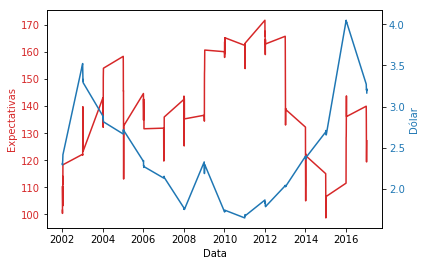

In [4]:
#criação do primeiro grafico
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Expectativas', color=color)
ax1.plot(exp_cam_df.index.values, exp_cam_df['valor'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

#concatenação dos dois gráficos em um gráfico de dois eixos y
ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Dólar', color=color)  
ax2.plot(exp_cam_df.index.values, exp_cam_df['cotacaoVenda'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig('exp_cam_graf.pdf')

    A correlação moderadamente negativa que obtivemos é sugerida pelo gráfico. Note que no período de 2010 a 2013, quando as expectativas estavam altas, o dólar se mostra em um patamar consideravelmente abaixo da média de nossa amostra.

# Teste ADF e teste de cointegração de Johansen

In [5]:
exp_ADF = ts.adfuller(exp_cam_df['valor'])
dol_ADF = ts.adfuller(exp_cam_df['cotacaoVenda'])

print("O p-valor para o teste ADF para a série das expectativas é de", exp_ADF[1],"e o p-valor para a série do dólar é de", dol_ADF[1],".\n")

O p-valor para o teste ADF para a série das expectativas é de 0.09714678404780974 e o p-valor para a série do dólar é de 0.457435270665434 .



    Visto que a hipótese nula do teste ADF não é rejeitada a 5% para nenhuma das séries, infiro que ambas sejam não estacionárias. Para evitar problemas de regressão espúria, farei o teste de cointegração antes da regressão, de modo a saber se há ou não necessidade de tirarmos a primeira diferença das séries para sua posterior análise.

In [6]:
#Realizar o teste de cointegração de Johansen com constante e sem tendência, com uma ordem de defasagem
coint_test = vecm.coint_johansen(exp_cam_df, det_order = 0, k_ar_diff = 1)
#Salvar as estatísticas de traço e autovetor
eig_stat = coint_test.lr2
trace_stat = coint_test.lr1
#Salvar os valores críticos das estatísticas de traço e autovetor
crit_trace_stat = coint_test.cvt
crit_eig_stat = coint_test.cvm

#Preparando resultados para output
trace1 = tuple(np.append(crit_trace_stat[0,:],trace_stat[0]))
trace2 = tuple(np.append(crit_trace_stat[1,:],trace_stat[1]))
eig1 = tuple(np.append(crit_eig_stat[0,:],eig_stat[0]))
eig2 = tuple(np.append(crit_eig_stat[1,:],eig_stat[1]))

In [7]:
print("Os valores críticos para a estatística de traço deste teste de Johansen, para a hipótese nula de menos de um vetor de cointegração, são de {} para 90%, {} para 95% e {} para 99%. O valor encontrado foi {}.\n".format(*trace1))
print("Os valores críticos para a estatística de traço deste teste de Johansen, para a hipótese nula de menos de dois vetores de cointegração, são de {} para 90%, {} para 95% e {} para 99%. O valor encontrado foi {}.\n".format(*trace2))
print("Os valores críticos para a estatística de autovetor deste teste de Johansen, para a hipótese nula de menos de um vetor de cointegração, são de {} para 90%, {} para 95% e {} para 99%. O valor encontrado foi {}.\n".format(*eig1))
print("Os valores críticos para a estatística de autovetor deste teste de Johansen, para a hipótese nula de menos de dois vetores de cointegração, são de {} para 90%, {} para 95% e {} para 99%. O valor encontrado foi {}.\n".format(*eig2))

Os valores críticos para a estatística de traço deste teste de Johansen, para a hipótese nula de menos de um vetor de cointegração, são de 13.4294 para 90%, 15.4943 para 95% e 19.9349 para 99%. O valor encontrado foi 18.983961846131493.

Os valores críticos para a estatística de traço deste teste de Johansen, para a hipótese nula de menos de dois vetores de cointegração, são de 2.7055 para 90%, 3.8415 para 95% e 6.6349 para 99%. O valor encontrado foi 3.717205870092211.

Os valores críticos para a estatística de autovetor deste teste de Johansen, para a hipótese nula de menos de um vetor de cointegração, são de 12.2971 para 90%, 14.2639 para 95% e 18.52 para 99%. O valor encontrado foi 15.26675597603928.

Os valores críticos para a estatística de autovetor deste teste de Johansen, para a hipótese nula de menos de dois vetores de cointegração, são de 2.7055 para 90%, 3.8415 para 95% e 6.6349 para 99%. O valor encontrado foi 3.717205870092211.



    Pelos resultados do teste de cointegração de Johansen, rejeitamos a nula da existência de um vetor de cointegração a um nível de significância de 5% pelo teste do traço. Apesar da hipótese nula teste de autovetor para a existência de dois vetores de cointegração ter sido rejeitada, adoto aqui o procedimento sugerido de tomar a primeira não-rejeição da nula como uma estimativa para o número de vetores de cointegração. Note também que a hipótese alternativa dos testes são diferentes: enquanto a hipótese alternativa do teste do traço para a existência de r = r* < k vetores de cointegração é r = r*, a alternativa para o teste dos autovetores é de que r = r* + 1. Então, ambos o testes do traço e dos autovetores indicam a existência de dois vetores de cointegração, indicando que as variáveis são cointegradas.

# Regressão e Análise

In [8]:
#preparando os dados para regressão
X = sm.add_constant(exp_cam_df['valor'])
Y = exp_cam_df['cotacaoVenda']

#rodar regressão
model = sm.OLS(Y,X)
results = model.fit()

#salvar resultados da regressão em arquivo de texto
with open('resultados_regressão.txt', 'w') as f:
    print('Filename:', results.summary(), file=f) 

#mostrar resultados da regressão
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           cotacaoVenda   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     30.01
Date:                Fri, 13 Jul 2018   Prob (F-statistic):           2.32e-07
Time:                        19:50:32   Log-Likelihood:                -105.59
No. Observations:                 125   AIC:                             215.2
Df Residuals:                     123   BIC:                             220.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4616      0.373     11.971      0.0

    A regressão resultou em parâmetros altamente significativos. O teste de Durbin Watson não rejeita a hipótese nula de ausência de autocorrelação do erro até a primeira defasagem a um nível de 10% de significância. O teste de Jarque-Bera, porém, rejeita fortemente a hipótese nula de normalidade dos resíduos.
    O coeficiente da regressão apresentou o sinal esperado, dada nossa hipótese. O efeito mostra-se altamente significativo, e de tamanho considerável: para cada 20 pontos a mais no índice de expectativas, aproximadamente seu desvio padrão, espera-se um aumento de 30 centavos no preço do dólar. Porém, para validarmos nossa hipótese, devemos realizar diagnósticos acerca das principais hipóteses do modelo clássico de regressão linear. Tratando-se de séries temporais não estacionárias, há sempre o risco de termos na verdade uma regressão espúria, caso os resíduos não sejam estacionários.

### Diagnósticos

    Nesta sessão, faremos os testes de hipóteses previamente citados. Comecemos pelos testes de heteroscedasticidade:

In [9]:
#salvar valores importantes para o diagnóstico
Y_hat = results.predict()
residual = Y - Y_hat

#realizar o teste de Breusch-Pagan
bp_test = dg.het_breuschpagan(residual, X)
bp_p = bp_test[3]

#realizar o teste de White
wh_test = dg.het_white(residual, X)
wh_p = wh_test[3]

print("O p-valor para o teste de heteroscedasticidade de Breusch-Pagan é de",het_p,"e para o de White é de", wh_p, ".\n")

NameError: name 'het_p' is not defined

    Apesar do teste de Breusch-Pagan não ter rejeitado a nula de ausência de heteroscedasticidade nem mesmo a 10% de significância, o teste de White rejeita a hipótese de homoscedasticidade a 1%. 

In [ ]:
#realizar o teste de Ljung-Box
lb_test = dg.acorr_ljungbox(residual, lags=10)
lb_p = lb_test[1]
print("P-valores para o teste Ljung-Box para defasagens de 1 a 10:")
print(lb_p)

    O teste de Ljung-Box contradiz o observado no teste de Durbin-Watson, mostrando p-valores de ordem de magnitude muito abaixo de 1% para as defasagens de 1 a 10. Isto pode ser um indicativo de não estacionariedade dos resíduos, visto que séries não estacionárias possuem forte presença de autocorrelação. Verificaremos isto no próximo teste.

In [ ]:
#realizar o teste ADF nos resíduos
res_ADF = ts.adfuller(residual)
res_ADF_p = res_ADF[1]

print("O p-valor do teste ADF para os resíduos é",res_ADF_p,".\n")

    O teste de Dickey-Fuller para o resíduo não rejeita a hipótese nula de não-estacionariedade do resíduo, botando em questão a cointegração das variáveis. Mostra-se então necessário fazer uma nova regressão, de tal modo que as séries utilizadas sejam estacionárias ou cointegradas. Faremos isto na próxima sessão. No entanto, com o propósito de estudo, continuaremos a explorar nossa regressão atual através de gráficos.

In [ ]:
#plotar gráfico de valores efetivos contra ajustados
fig, ax = plt.subplots()
ax.plot(exp_cam_df['valor'], Y, 'o')
ax.plot(exp_cam_df['valor'], Y_hat, 'b-')
ax.set_ylabel('Dólar')
ax.set_xlabel('Expectativas')
ax.set_title('Efetivo vs ajustado')

#salvar grafico em arquivo pdf
plt.savefig('regressao_grafico.pdf')


In [ ]:
#plotar grafico dos resíduos
fig, ax3 = plt.subplots()
ax3.plot(exp_cam_df['valor'], residual, 'o')
ax3.set_ylabel('Resíduo')
ax3.set_xlabel('Expectativas')
ax3.set_title('Gráfico dos resíduos')

#salvar gráfico
plt.savefig('regressao1_grafico_residuos.pdf')


    Ambos os gráficos dos valores ajustados contra os efetivos e dos resíduos contra as expectativas não se mostram particularmente iluminadores. O segundo gráfico sugere uma possível relação entre o regressor e os resíduos, pois os segundos são ligeiramente maiores conforme o regressor aumenta. Se verdade, isto quebraria a hipótese de exogeneidade, tornando nossos estimadores viesados. Com vista no problema de raiz unitária nos resíduos previamente discutido, prosseguiremos na próxima sessão com um novo modelo, desta vez tomando a primeira diferença de nossas séries.

### Segunda Regressão: primeiras diferenças

    Nesta seção, faremos uma nova regressão com as primeiras diferenças de nossas séries. Para isto, primeiro faremos um rápido tratamento e análise exploratória dos dados em questão após tirarmos sua primeira diferença.

In [ ]:
#tirar a primeira diferença
delta_df = exp_cam_df.diff()
#tirar a primeira linha por conta de valores NaN
delta_df = delta_df[1:]
delta_X = delta_df['valor']
delta_Y = delta_df['cotacaoVenda']

In [ ]:
#criação do primeiro grafico
fig, ax4 = plt.subplots()

color = 'tab:red'
ax4.set_xlabel('Data')
ax4.set_ylabel('Variação das expectativas', color=color)
ax4.plot(delta_df.index.values, delta_X, color=color)
ax4.tick_params(axis='y', labelcolor=color)

#concatenação dos dois gráficos em um gráfico de dois eixos y
ax5 = ax4.twinx() 

color = 'tab:blue'
ax5.set_ylabel('Variação do dólar', color=color)  
ax5.plot(delta_df.index.values, delta_Y, color=color)
ax5.tick_params(axis='y', labelcolor=color)

plt.savefig('grafico_primeira_dif.pdf')

In [ ]:
dexp_ADF = ts.adfuller(delta_X)
ddol_ADF = ts.adfuller(delta_Y)

print("O p-valor para o teste ADF para a série das expectativas é de", dexp_ADF[1],"e o p-valor para a série do dólar é de", ddol_ADF[1],".\n")

    Após tirar a primeira diferença, ambas as séries se tornaram estacionárias, e, portanto, são I(1). Notavelmente, o gráfico das duas para de sugerir a correlação negativa observada na primeira sessão. Prosseguiremos fazendo uma regressão para verificar se ainda há alguma relação negativa entre as duas variáveis.

In [ ]:
delta_X_r = sm.add_constant(delta_X)

#rodar regressão
dmodel = sm.OLS(delta_Y,delta_X_r)
dresults = dmodel.fit()

#salvar resultados da regressão em arquivo de texto
with open('resultados_regressão_primeira_dif.txt', 'w') as f:
    print('Filename:', dresults.summary(), file=f) 

#mostrar resultados da regressão
print(dresults.summary())

    A regressão entre as primeiras diferenças não apresenta nenhum coeficiente significante. A estatística F de significância global também não rejeita a hipótese nula conjunta de irrelevância da constante e das expectativas para a determinação do preço do dólar. Concluio, então, que a regressão anterior era um clássico caso de regressão espúria. Não há propósito, então, em fazer testes de hipóteses para o modelo, visto que este é rejeitado pela evidência.

# Conclusão

    Neste trabalho, analisamos a relação entre o Índice de Expectativas do Banco Central e do preço do dólar no Brasil. Minha hipótese inicial, de que havia uma relação negativa entre as duas variáveis, foi aceita em um primeiro momento pela nossa regressão, que, porém, mostrou ser espúria. Uma nova regressão tratando das primeiras diferenças das variáveis em questão (que, diga-se de passagem, são estacionárias) indicou a não existência de nenhuma relação linear entre ambas. 